# Optimizing the eigen computation
## For Kaggle's NCAA competition

[Kaggle](http://www.kaggle.com) is a company that runs competitions in Data Science. For the fifth year in a row, they're running an NCAA tourney competition - [one for the men's bracket](https://www.kaggle.com/c/mens-machine-learning-competition-2018) and [one for the women's bracket](https://www.kaggle.com/c/womens-machine-learning-competition-2018). Let's use the tools we've developed to give it a try!

### A description of the competition

This is not the run of the mill, office or ESPN type competition. You are asked, not just to predict winners, but to associate a probability with each prediction. To enter, you create a file; the first few lines should look something like so:

    id,pred
    2018_1112_1122,0.96
    2018_1112_1124,0.82
    
This states that for this year, you believe that the team with ID 1112 will beat the team with ID 1122 with probability 0.96. Thus, you're quite confident in that prediction. You're somewhat less confident that they'll beat the team with ID 1124. Note that you need to predict every *possible* game before the tournament starts (excluding the first four). Thus your entry should have 

$$\left(\begin{array}{c}64\\2\end{array}\right)+1 = 2017$$
rows. You can enter before the first four begins, in which case your file will be a bit longer.

Your entry is scored using a LogLoss computation:

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],$$

where the sum is performed after the fact using only those games that have actually been played and

 * $n$ is the number of games played,
 * $\hat{y}_i$ is the predicted probability of team 1 beating team 2,
 * $y_i$ is 1 if team 1 wins, 0 if team 2 wins, and
 * $\log$ is the natural logarithm.

Since we've got an approach to ranking teams that depends upon a number of parameters, we'll try to optimize our approach against historical data to see if we can find good choices for those parameters.

### Kaggle's data

Kaggle provides a ton of data

 * `Teams.csv` - a list of teams with unique IDs referenced in other files.
 * `RegularSeasonCompactResults.csv` - Results on over 150000 games played 1985-2017. Includes
 who played, who won, who's court, the score, and number of overtimes.
 * `NCAATourneyCompactResults.csv` - Results from the NCAA tournament for all games played 1985-2017.

All this data is available via the [Get the data](https://www.kaggle.com/c/march-machine-learning-mania-2016/data) link at the top of that page, though, you have to be signed in to actually download it. You can sign in via Google or Facebook, so it's not so hard. Either way, *none of the code in this notebook will work, unless it lives in the same directory as the DataFiles folder provided by Kaggle*.

### Code

Let's get to it!

#### Imports

In [1]:
## You'll just need to execute this once.

# Standard
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Time a lengthy computation
from time import time

# A tool for getting data
import pandas as pd

# A sparse matrix representation
from scipy.sparse import dok_matrix

# An eigenvalue computer for sparse matrices
from scipy.sparse.linalg import eigs

# We'll need to optimize our procedure.
from scipy.optimize import minimize

#### Reading in and setting up the data for the basic eigen-computation

We'll use Pandas' `read_csv` command to read in the data. We'll store necessary stuff in some dictionaries for quick access.

In [2]:
## You'll just need to execute this once.

teams_df = pd.read_csv('DataFiles/Teams.csv')
teams = [
    {
        'team_idx':idx,
        'team_id':row['TeamID'], 
        'team_name':row['TeamName']
    }
    for (idx,row) in teams_df.iterrows()
]

We'll do the same thing with the game data for a given year, which is a bit more complicated.

In [3]:
## Read in and set up the season results data for a particular year.
## Note that this is the one and only place we set the year. You'll
## need to rerun this every time through.

year = 2017

# Load the regular season data
results_df = pd.read_csv('DataFiles/RegularSeasonCompactResults.csv')
games = [
    {
        'day':int(row['DayNum']),
        'win_id':row['WTeamID'],
        'win_score':int(row['WScore']),
        'lose_id':row['LTeamID'],
        'lose_score':int(row['LScore']),
        'win_loc':row['WLoc'],
        'num_ot':row['NumOT']
    }
    for (idx,row) in results_df.iterrows() if row['Season'] == year
]
min_day = min([game['day'] for game in games])
max_day = max([game['day'] for game in games])

# Load the tournament results data - for scoring purposes
tourney_results_df = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
tourney_results = []
for idx,row in tourney_results_df.iterrows():
    if row['Season'] == year:
        win_team = row['WTeamID']
        lose_team = row['LTeamID']
        tourney_results.append((win_team,lose_team))

The previous input read in and set up some important data for us. Specifically, `games` is a list of dictionaries that look like so:

    {'day': 7,
     'lose_id': '1414',
     'lose_score': 65,
     'num_ot': '0',
     'win_id': '1228',
     'win_loc': 'H',
     'win_score': 79}

That's just one example that's pretty self-explanatory. Note that the `'win_id'` and `'lose_id'` refer to numeric strings assigned by Kaggle. 

We also set up a list of tourney results that looks like so:

    [(1243, 1448),(1291, 1309),(1413, 1300),...]
    
That just tells us who actually beat who.

Finally, we need a `team_dict` that quickly gives us basic info about each team, given it's Kaggle ID.

In [4]:
## You'll need to execute this each time you try a different year -
## including running the final version for 2018!

team_dict = {}
for game in games:
    win_team = game['win_id']
    if win_team in team_dict:
        team_dict[win_team]['num_games'] = team_dict[win_team]['num_games']+1
    else:
        team_dict[win_team] = {'num_games':1}
    lose_team = game['lose_id']
    if lose_team in team_dict:
        team_dict[lose_team]['num_games'] = team_dict[lose_team]['num_games']+1
    else:
        team_dict[lose_team] = {'num_games':1}
n_games = len(team_dict)
cnt = 0
for team in team_dict:
    team_dict[team]['matrix_idx'] = cnt
    cnt = cnt+1
    pos = [team['team_id'] for team in teams].index(team)
    team_dict[team]['name'] = teams[pos]['team_name']
reverse_team_dict = dict([(team_dict[team]['matrix_idx'],team) for team in team_dict])

The first few entries of `team_dict` look like so:

    {'1102': {'matrix_idx': 244, 'name': 'Air Force', 'num_games': 28},
     '1103': {'matrix_idx': 166, 'name': 'Akron', 'num_games': 34},
     '1104': {'matrix_idx': 45, 'name': 'Alabama', 'num_games': 32}, ... }

I guess that `'name'` and `'num_games`' are self explanatory. The `'matrix_idx'` key tells us how each team is associated with the game matrix.

#### Performing the basic eigen-ranking

I guess the very simplest matrix we could use is to place the number of times that team $i$ beat team $j$ in row $i$ and column $j$. The dominant eigenvector then yields a (*very rough*) ranking of the teams. 

In [5]:
## This doesn't need to be run.

M = dok_matrix((len(team_dict),len(team_dict)))
for game in games:
    win_team = game['win_id']
    win_index = team_dict[win_team]['matrix_idx']
    lose_team = game['lose_id']
    lose_index = team_dict[lose_team]['matrix_idx']
    M[win_index,lose_index] = M[win_index,lose_index] + 1
value, vector = eigs(M, which = 'LM', k=1)
vector = abs(np.ndarray.flatten(vector.real))
order = list(vector.argsort())
order.reverse()
ranking = [(vector[k],team_dict[reverse_team_dict[k]]['name']) for k in order]
ranking[:10]

[(0.2024264916682256, 'Villanova'),
 (0.19319356993641176, 'Duke'),
 (0.17632489014806782, 'North Carolina'),
 (0.16578773745535982, 'Florida St'),
 (0.15661992188496002, 'Kansas'),
 (0.15361345861802286, 'Louisville'),
 (0.15193507416648738, 'Michigan'),
 (0.1515452128456225, 'Butler'),
 (0.15110245537761, 'Wisconsin'),
 (0.15024947567008634, 'Notre Dame')]

### Interpreting our rankings as probabilities

Super! But how can we use this to compute probabilities? For example, what's the probability that the UNC beats the $180^{\text{th}}$ team, who happens to be UNCA?

In [6]:
## This doesn't need to be run.

team180_matrix_idx = order[180]
team180_kaggle_idx = reverse_team_dict[team180_matrix_idx]
team_dict[team180_kaggle_idx]['name']

'UNC Asheville'

If team 1 and team 2 have strengths $s_1$ and $s_2$, then a very simple and natural approach might be to use 

$$\frac{s_1}{s_1+s_{2}}.$$

While this makes *some* sense in that it at least satisfies the basics of probability theory, it yields the following probability estimate that UNC would've beaten UNCA last year.

In [7]:
## This doesn't need to be run.

team2_matrix_idx = order[2]
team2_strength = vector[team2_matrix_idx]
team180_strength = vector[team180_matrix_idx]
team2_strength/(team2_strength + team180_strength)

0.87767518585617843

Clearly, the probability should be a bit higher - well over 90% and maybe 98 or 99%. I propose that we scale the probabilities with a function that looks something like so:

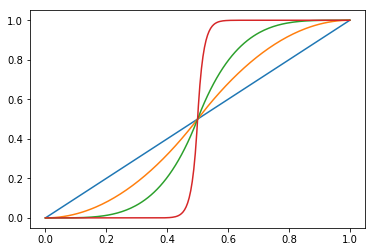

In [8]:
## This doesn't need to be run.

def scale(s,x): 
    if x<=0.5:
        return 0.5*(2*x)**(1/s)
    else:
        return 1-0.5*(2*(1-x))**(1/s)

xs = np.linspace(0,1,200)
for s in (1,0.5,0.25,0.0358):
    plt.plot(xs,[scale(s,x) for x in xs])

Thus, our previous computation might become something like so:

In [9]:
## This doesn't need to be run.

scale(0.3, team2_strength/(team2_strength + team180_strength))

0.99542084646642259

Of course, a reasonable value of $s$ is tweakable. Regardless, I emphasize that this is just a simple, intuitive tweak. A better approach would be to compare the correlation between eigen-strenghts and actual historical win percentage to obtain something like a $p$-value for our prediction. Maybe next year!

On the other hand, from the numerical analysis perspective, we might ignore the "probability" interpretation and simply view this as a minimization of the LogLoss with `scale`'s `s` parameter as one of the parameters in the minimization.

### A more detailed game matrix

Of course, the big question is - what *exactly* should the game matrix be in terms of all the information at our disposal?  If $M=(m_{ij})$, I guess we need formulae for $m_{ij}$ and $m_{ji}$ expressed in terms of the results of the games played between team $i$ and team $j$. The exact contribution to $m_{ij}$ from one particular game might depend on a number of factors, such as

  - The winner and loser
  - The score
  - When the game was played
  - Where the game was plaed
  - The total number of games played by each team

Of course, there are many other factors that might be considered, but the factors above are the ones we consider here and they are all in Kaggle's data. The specific formua we use below to determine the contribution of one game between team $i$ and team $j$ looks like

$$aw \times dw \frac{ww \times w + sw \times s/t}{n^p},$$

where

  - $aw$ is the away weight - i.e., how much an away victory is valued vs a home victory
  - $dw$ is the day weight - how much we weight a game in termes of when it was played
  - $ww$ is the win weight -  how much we weight victory
  - $w$ is one or zero depending on whether team $i$ won or lost this game
  - $sw$ is the score weight - how much we weight the score
  - $s$ is team $i$'s score
  - $t$ is the total score
  - $n$ is the number of games team $i$ played
  - $p$ is a non-negative exponent

### Running a trial

The `run_trial` function defined below is the function that we're going to try to minimize. It's a long function because it incorporates most of the code we've seen to this point and a bit more. It accepts a list of the above parameters, constructs the corresponding game matrix, computes the dominant eigenvector, uses the scale function to produce predicted win probabilities, and uses the known tourney results to compute the corresponding Kaggle score that would have resulted that year. We can optionally get extra information on the results.

In [10]:
## You'll need to rerun this every time you perform optimization for a given year.

def scale(s,x): 
    if x<=0.5:
        return 0.5*(2*x)**(1/s)
    else:
        return 1-0.5*(2*(1-x))**(1/s)
def run_trial(parameters, extra_info=False):
    aw = parameters[0]
    sw = parameters[1]
    ww = parameters[2]
    p = parameters[3]
    day_weight = parameters[4]
    def dw(day):
        return day_weight + (1-day_weight)*(day-min_day)/(max_day-min_day)
    s = parameters[5]
    
    M = dok_matrix((len(team_dict),len(team_dict)))
    for game in games:
        day_weight = dw(game['day'])
        win_team = game['win_id']
        w_num_games = team_dict[win_team]['num_games']**p
        win_score = int(game['win_score'])
        win_index = team_dict[win_team]['matrix_idx']
        lose_team = game['lose_id']
        l_num_games = team_dict[lose_team]['num_games']**p
        lose_score = int(game['lose_score'])
        lose_index = team_dict[lose_team]['matrix_idx']
        total_score = win_score+lose_score
        if game['win_loc'] == 'H':
            whw = 1
            lhw = aw
        elif game['win_loc'] == 'A':
            whw = aw
            lhw = 1
        else:
            whw = 1
            lhw = 1
        M[win_index,lose_index] = M[win_index,lose_index] + whw*day_weight*ww/w_num_games + \
            (whw*day_weight*sw*win_score/total_score)/w_num_games
        M[lose_index,win_index] = M[lose_index,win_index] +  \
            (lhw*day_weight*sw*lose_score/total_score)/l_num_games
    value, vector = eigs(M, which = 'LM', k=1)
    vector = abs(np.ndarray.flatten(vector.real))
    order = list(vector.argsort())
    order.reverse()

    def prob1beats2(team1,team2):
        strength1 = vector[team_dict[team1]['matrix_idx']]
        strength2 = vector[team_dict[team2]['matrix_idx']]
        return scale(s, strength1/(strength1+strength2))
    
    total = 0
    cnt = 0
    for result in tourney_results:
        total = total + np.log(prob1beats2(result[0],result[1]))
        cnt = cnt+1    
    score = -total/cnt
    if extra_info == True:
        extra_info_dict = {
            'ranking_vector': vector,
            'order': order,
            'p_function': prob1beats2,
            'ranking': [team_dict[reverse_team_dict[k]]['name'] for k in order]
        }
        return score, extra_info_dict
    else:
        return score

Note that `parameters` is the list of input parameters. We can use them like so:

In [11]:
## This doesn't need to be run.

# Give a little boost to an away win
aw = 1.3

# Value wins more than scores
sw = 1
ww = 1.5

# Regular normalization per Keener
p = 1

# Games from the beginning of the season count only 3/4 as much as current games.
dw = 0.75

# Probability scaler
s = 0.1

# Run it!
run_trial([aw,sw,ww,p,dw,s])

0.60129607126587292

Here's what it looks like if you ask for the `extra_info`:

In [12]:
## This doesn't need to be run.

result, info = run_trial([aw,sw,ww,p,dw, s], extra_info = True)

Thus, for example, we can use the function stored in `info['p_function']` to compute the probability that UNC beats UNCA.

In [13]:
## This doesn't need to be run.

unc_kaggle_idx = 1314
unca_kaggle_idx = 1421
p_fun = info['p_function']
p_fun(unc_kaggle_idx, unca_kaggle_idx)

0.96005568476040704

And we can score this `p_function` against the actual tourney results that we read in earlier.

In [14]:
## This doesn't need to be run.

total = 0
cnt = 0
for result in tourney_results:
    total = total + np.log(p_fun(result[0],result[1]))
    cnt = cnt+1    
score = -total/cnt
score

0.60129607126587492

Remember that randomly assigning each team a 50/50 chance results in a score of $\log(2)\approx0.693$, so I guess we're getting better. To improve it more, let's try SciPy's `optimize.minimize` function. This takes an unfortunate amount of time, but will (hopefully) improve the reult.

In [15]:
## Here's where we actually find parameters to optimize the procedure!!

aw = 1.3; sw = 1; ww = 1.5; p = 1; dw = 0.75; s = 0.1
t = time()
min_result = minimize(run_trial, [aw,sw,ww,p,dw,s], 
    bounds =  [(1,None), (0.1, None), (0, None), (0,None), (0,1),(0.01,1)])
time()-t

111.911062002182

Takes a minute or two on my machine, depending on the year. Let's examine the result.

In [16]:
## This is the important output that you want from the optimization!!

min_result

      fun: 0.49276522747105633
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.62479394e-01,  -8.32667268e-08,  -1.01585407e-06,
         4.26325641e-06,  -4.22740176e-02,   1.38722367e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 343
      nit: 24
   status: 0
  success: True
        x: array([ 1.        ,  1.4347571 ,  0.01574776,  0.93253358,  1.        ,
        0.03178299])

The result is essentially a dict with some extra methods for formatting. Of particular interest are the `fun` and `x` keys. Of course, we like that  `success` is `True`! The contents of `result['fun']` tells us the minimum that was found. Since this is about `0.49276`, we see that we've improved on our initial attempt. Since $x$ is so often used as a generic input variable, `result['x']` tells us the input to achieve the minimum. Thus, the mimum was achieved with input parameters of about

    [1., 1.4347571, 0.01574776,  0.93253358,  1., 0.03178299]

Referring back to the purposes of these parameters, we find that home vs away does not appear important, that scores count considerably more than just wins, that the normalization is only by about the square root of the number of games, that date played is ignored, and that the probability scaling factor  is about $0.03$.

Let's run the trial with these new parameters and check out the rankings:

In [17]:
## This doesn't need to be run, but examining the top 10 might 
## help ensure that your results are sensible

result, info = run_trial(min_result['x'], extra_info = True)
info['ranking'][:10]

['Villanova',
 'North Carolina',
 'Kentucky',
 'Virginia',
 'West Virginia',
 'Louisville',
 'Gonzaga',
 'Duke',
 'Kansas',
 'Florida']

## Creating a submission file

**You'll need to run all the code from here to create the submission file!! Be sure to rerun everything above for 2018 before doing so.**

The filetype that Kaggle expects is detailed [on their evaluation page](https://www.kaggle.com/c/march-machine-learning-mania-2016/details/evaluation). The first few lines should look something like so:

    id,pred
    2018_1112_1114,0.91
    2018_1112_1122,0.96
    2018_1112_1124,0.82

We can create such a file as follows. First, we load the tourney seeds for this year, so we know who's in the tournament and so we can use our historical win probability function as part of our computation.

In [18]:
seeds_df = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
seed_dict = {};
for (idx,row) in list(seeds_df.iterrows()):
    if row['Season'] == year:
        team = row['TeamID']
        seed = int(row['Seed'][1:3])
        seed_dict[team] = seed
teams_in = list(seed_dict.keys())
teams_in.sort()
pairs = [(teams_in[i], teams_in[j]) 
    for i in range(len(teams_in)) 
    for j in range(i+1,len(teams_in))]

Rather than a `run_trial` function that computes our score (which we have no way of knowing yet), we write a `run_it` function that returns the `p_function` and `rankings` given particular input parameters.

In [19]:
def scale(s,x): 
    if x<=0.5:
        return 0.5*(2*x)**(1/s)
    else:
        return 1-0.5*(2*(1-x))**(1/s)
def run_it(parameters):
    aw = parameters[0]
    sw = parameters[1]
    ww = parameters[2]
    p = parameters[3]
    day_weight = parameters[4]
    def dw(day):
        return day_weight + (1-day_weight)*(day-min_day)/(max_day-min_day)
    s = parameters[5]
    
    M = dok_matrix((len(team_dict),len(team_dict)))
    for game in games:
        day_weight = dw(game['day'])
        win_team = game['win_id']
        w_num_games = team_dict[win_team]['num_games']**p
        win_score = int(game['win_score'])
        win_index = team_dict[win_team]['matrix_idx']
        lose_team = game['lose_id']
        l_num_games = team_dict[lose_team]['num_games']**p
        lose_score = int(game['lose_score'])
        lose_index = team_dict[lose_team]['matrix_idx']
        total_score = win_score+lose_score
        if game['win_loc'] == 'H':
            whw = 1
            lhw = aw
        elif game['win_loc'] == 'A':
            whw = aw
            lhw = 1
        else:
            whw = 1
            lhw = 1
        M[win_index,lose_index] = M[win_index,lose_index] + whw*day_weight*ww/w_num_games + \
            (whw*day_weight*sw*win_score/total_score)/w_num_games
        M[lose_index,win_index] = M[lose_index,win_index] +  \
            (lhw*day_weight*sw*lose_score/total_score)/l_num_games
    value, vector = eigs(M, which = 'LM', k=1)
    vector = abs(np.ndarray.flatten(vector.real))
    order = list(vector.argsort())
    order.reverse()

    def prob1beats2(team1,team2):
        strength1 = vector[team_dict[team1]['matrix_idx']]
        strength2 = vector[team_dict[team2]['matrix_idx']]
        return scale(s, strength1/(strength1+strength2))
    
    team_dicts = [team_dict[reverse_team_dict[k]] for k in order]
    for idx,td in enumerate(team_dicts):
        td['rating'] = vector[order][idx]
    
    return {
        'ranking_vector': vector,
        'order': order,
        'p_function': prob1beats2,
        'rankings': [team_dict[reverse_team_dict[k]] for k in order]
    }

Here's an example and the resulting rankings.

In [20]:
attempt = run_it([1.1, 1.0, 0.01, 0.9, 1.0, 0.025])
[x['name'] for x in attempt['rankings'][:10]]

['Villanova',
 'Virginia',
 'North Carolina',
 'West Virginia',
 'Kentucky',
 'Gonzaga',
 'Louisville',
 'Duke',
 'Florida',
 'Kansas']

Finally, the following code will create your submission file called `submit.csv`.

In [21]:
p_fun = attempt['p_function']
file_handle = open('submit.csv', 'w')
file_handle.write("id,pred\n")
for pair in pairs:
    line = str(year) + "_" + str(pair[0]) + "_" + str(pair[1]) + ","
    p = p_fun(pair[0], pair[1])
    p = str(p)
    line = line + p
    #line = line + ",\t" + team_dict[pair[0]]['name'] + " - " + team_dict[pair[1]]['name']
    line = line + "\n"
    file_handle.write(line)
file_handle.close()

### Viewing the tournament

You've got a couple of choices for viewing the tournament based on this work. If you want to use the submission file you just generated and see how it will score based Kaggle's LogLoss scoring method, you can [upload it here](https://www.marksmath.org/visualization/kaggle_brackets/). 

Alternatively, if you'd like to see how your bracket would play out based on the rankings, you can always use our little tool from just before break. For example, here's the Sweet Sixteen from last year listed in the correct order:

In [22]:
sweet_sixteen = [
    'Wisconsin', 'Florida',
    'Baylor', 'South Carolina',
    'Gonzaga', 'West Virginia',
    'Xavier', 'Arizona',
    'Kansas', 'Purdue',
    'Oregon', 'Michigan',
    'North Carolina', 'Butler',
    'UCLA', 'Kentucky'
]

We can create a query string for our tournament viewer as follows:

In [23]:
ranked_teams = attempt['rankings']
team_names = [t['name'] for t in ranked_teams]
def get_rating(t):
    idx = team_names.index(t)
    return ranked_teams[idx]['rating']

q = "?"
for k in range(16):
    q = q + 'team=' + sweet_sixteen[k] + '&'
    q = q + 'rating=' + str(get_rating(sweet_sixteen[k]))
    if k<15:
        q = q + '&'
q

'?team=Wisconsin&rating=0.0604419544881&team=Florida&rating=0.0613198630422&team=Baylor&rating=0.0605873153536&team=South Carolina&rating=0.0588211460809&team=Gonzaga&rating=0.0617443705891&team=West Virginia&rating=0.0620660932983&team=Xavier&rating=0.0583528409311&team=Arizona&rating=0.0592027576035&team=Kansas&rating=0.061245279968&team=Purdue&rating=0.0606339703899&team=Oregon&rating=0.0596649464498&team=Michigan&rating=0.0604510986341&team=North Carolina&rating=0.0620698762182&team=Butler&rating=0.0597035012317&team=UCLA&rating=0.0589164092671&team=Kentucky&rating=0.0617730363134'

And then we can just pass query string to our groovy little tool:

In [24]:
import webbrowser
webbrowser.open(
    'https://marksmath.org/visualization/eigenbrackets/tourney_from_rankings.html' + q
)

True

That should open a webpage containing a tournament that looks something like so:

![ss2017](sweet_sixteen_2017_predicted.png)

Alternatively, you can follow [this link](https://marksmath.org/visualization/eigenbrackets/tourney_from_rankings.html?team=Wisconsin&rating=0.0604419544881&team=Florida&rating=0.0613198630422&team=Baylor&rating=0.0605873153536&team=South%20Carolina&rating=0.0588211460809&team=Gonzaga&rating=0.0617443705891&team=West%20Virginia&rating=0.0620660932983&team=Xavier&rating=0.0583528409311&team=Arizona&rating=0.0592027576035&team=Kansas&rating=0.061245279968&team=Purdue&rating=0.0606339703899&team=Oregon&rating=0.0596649464498&team=Michigan&rating=0.0604510986341&team=North%20Carolina&rating=0.0620698762182&team=Butler&rating=0.0597035012317&team=UCLA&rating=0.0589164092671&team=Kentucky&rating=0.0617730363134) in an semi up to date web browser.